# Creating Figures Strong Corr

## Creating Panel B

In [1]:
from lib.figure_5 import get_fig_5_panel_b

get_fig_5_panel_b()

AKED0620210804:   5%|▍         | 414/8366 [03:53<1:22:23,  1.61it/s]

: 

## Panel C Mono

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename

from lib.file_utils import get_dms_pfc_paths_mono
from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_response_bg_firing

mono_pairs = get_dms_pfc_paths_mono()

phase_diffs = []
phase_diffs_bg = [] 
for ind, row in mono_pairs.iterrows():
    behaviour_data = pd.read_csv(row['session_path'])
    pfc_times = np.load(row['pfc_path'])
    str_times = np.load(row['str_path'])

    cue_times = behaviour_data['cue_time'].tolist()
    pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
    str_mag, str_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)

    phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=str_mag, dms_bg=str_bg)
    phase_diffs.append(phase_d)
    phase_diffs_bg.append(phase_d_bg)

fig_path = pjoin('figures', 'figure_5', 'panel_c', 'mono_all.jpg')
fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36)
fig.savefig(fig_path, dpi=300)

## Panel D Mono

In [ ]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=True, bin_size=36, zero_ymin=True)

## Panel C All

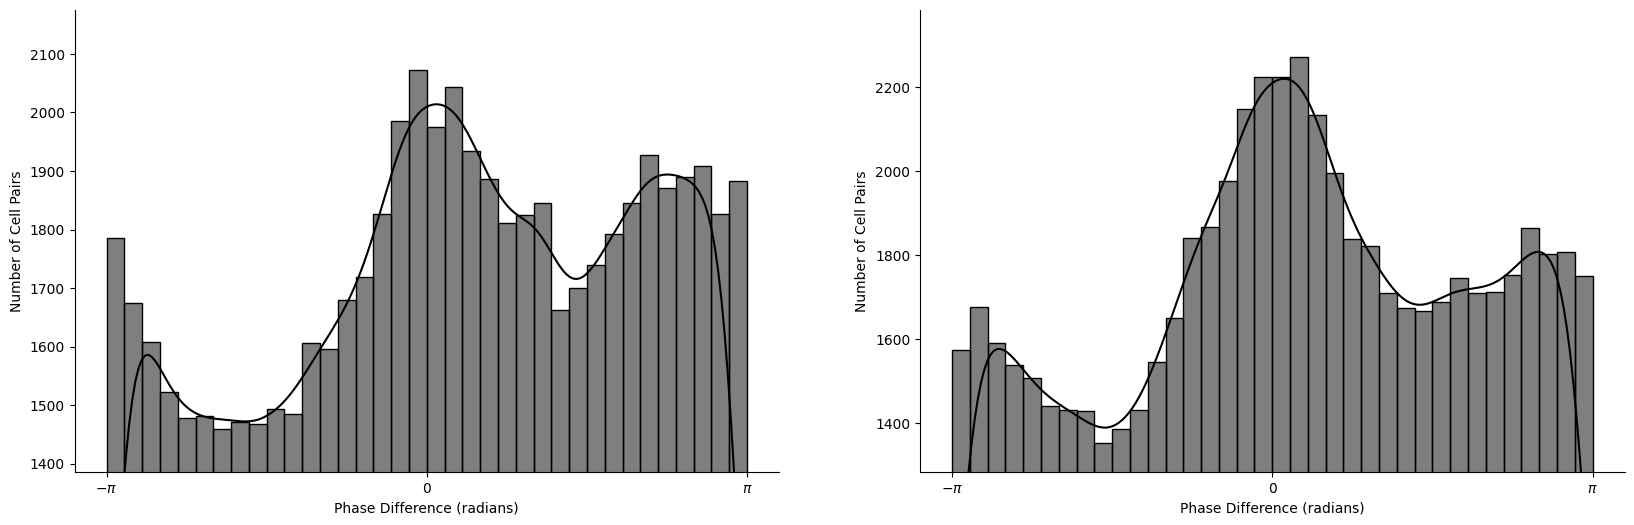

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir

from lib.figure_5 import fig_5_panel_c, phase_diff_pfc_dms
from lib.calculation import get_session_performances, get_response_bg_firing

phase_diffs = []
phase_diffs_bg = [] 
bin_size = 100

performances, cutoff = get_session_performances()
spike_data_root = pjoin('data', 'spike_times', 'sessions')
behaviour_root = pjoin('data', 'behaviour_data')

for session_name in listdir(spike_data_root):
    behaviour = pjoin(behaviour_root, session_name + '.csv')
    behaviour_data = pd.read_csv(behaviour)
    cue_times = behaviour_data['cue_time'].tolist()
    for pfc in glob(pjoin(spike_data_root, session_name, 'pfc_*')):
        pfc_times = np.load(pfc)
        for dms in glob(pjoin(spike_data_root, session_name, 'dms_*')):
            str_times = np.load(dms)
            pfc_mag, pfc_bg = get_response_bg_firing(cue_times=cue_times, spike_times=pfc_times)
            dms_mag, dms_bg = get_response_bg_firing(cue_times=cue_times, spike_times=str_times)
            phase_d, phase_d_bg = phase_diff_pfc_dms(pfc_mag=pfc_mag, pfc_bg=pfc_bg, dms_mag=dms_mag, dms_bg=dms_bg)
            phase_diffs.append(phase_d)
            phase_diffs_bg.append(phase_d_bg)


fig = fig_5_panel_c(phase_diffs=phase_diffs, phase_diffs_bg=phase_diffs_bg, bin_size=36, zero_ymin=False)

## Panel D All

100%|██████████| 29/29 [02:09<00:00,  4.48s/it]


AKED0520210715
AKED0120210723
AKED0220210731
AKED0120210801
AKED0220210730
AKED0420210806
AKED0220210801
AKED0220210802
AKED0520210727
AKED0520210726
AKED0620210803
AKED0120210721
AKED0520210725
AKED0520210719
AKED0220210804
AKED0220210729
AKED0120210729


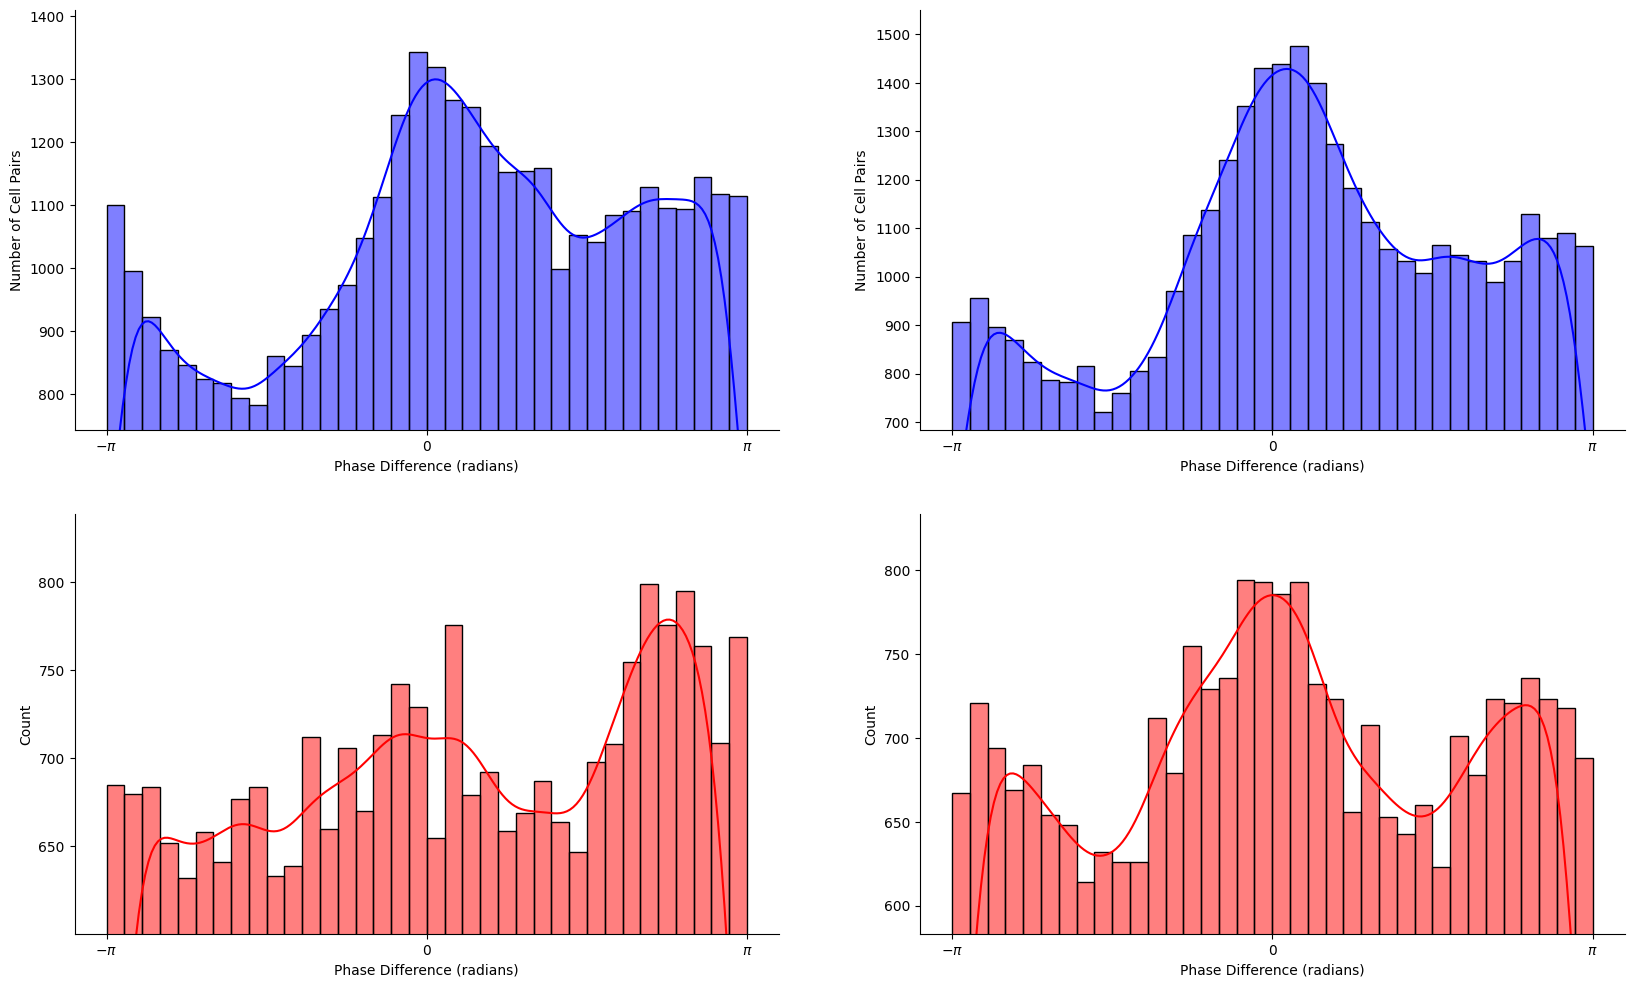

In [1]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=False, bin_size=36, zero_ymin=False)

In [ ]:
from lib.figure_5 import get_figure_5_panel_d

get_figure_5_panel_d(mono=True, bin_size=36, zero_ymin=False)

## Check relative value and PRPD correlation

In [ ]:
# for each session, load the relative value and the PRPD
# plot the PRPD against the relative value

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from os.path import join as pjoin
from os.path import basename
from os import listdir

from lib.calculation import moving_window_mean_prior

for session in glob(pjoin('data', 'relative_values', '*.npy')):
    session = basename(session)
    session_name = session.split('.')[0]
    relative_value_path = pjoin('data', 'relative_values', session)
    relative_value = np.load(relative_value_path)
    # smoothen the relative value
    relative_value = moving_window_mean_prior(relative_value, 20)
    prpd_path = pjoin('data', 'prpd', session)
    prpd = np.load(prpd_path)
    # load the behaviour data and remove the nan trials in prpd
    behaviour_data = pd.read_csv(pjoin('data', 'behaviour_data', session_name + '.csv'))
    prpd = prpd[~np.isnan(behaviour_data['trial_reward'])]
    
    # plot PRPD and relative values as twin x line plot
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(prpd, color='blue')
    ax2.plot(relative_value, color='red')
    ax1.set_ylabel('PRPD', color='blue')
    ax2.set_ylabel('Relative Value', color='red')
    ax1.set_xlabel('Trial Number')
    fig.suptitle(session_name)
    plt.show()
    plt.close()

# Panel E

In [ ]:
from lib.figure_5 import get_figure_5_panel_e

fig = get_figure_5_panel_e(mono=False, no_nan=False, zero_ymin=False)

In [ ]:
from lib.figure_5 import get_figure_5_panel_e

fig = get_figure_5_panel_e(mono=True, no_nan=True, zero_ymin=False)

## Plateau and transition trials

In [ ]:
from lib.figure_5 import get_figure_5_panel_extra

fig = get_figure_5_panel_extra(mono=False, no_nan=False, zero_ymin=False)